Sequential output shape:	 torch.Size([1, 64, 64, 64])
Sequential output shape:	 torch.Size([1, 64, 64, 64])
Sequential output shape:	 torch.Size([1, 128, 32, 32])
Sequential output shape:	 torch.Size([1, 256, 16, 16])
Sequential output shape:	 torch.Size([1, 512, 8, 8])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 100])
Training on GPU
train size:16517,test size:1836
['maclura_pomifera', 'ulmus_rubra', 'broussonettia_papyrifera', 'prunus_virginiana', 'acer_rubrum', 'cryptomeria_japonica', 'staphylea_trifolia', 'asimina_triloba', 'diospyros_virginiana', 'tilia_cordata', 'ulmus_pumila', 'quercus_muehlenbergii', 'juglans_cinerea', 'cercis_canadensis', 'ptelea_trifoliata', 'acer_palmatum', 'catalpa_speciosa', 'abies_concolor', 'eucommia_ulmoides', 'quercus_montana', 'koelreuteria_paniculata', 'liriodendron_tulipifera', 'styrax_japonica', 'malus_pumila', 'prunus_sargentii', 'cornus_mas', 'magnoli

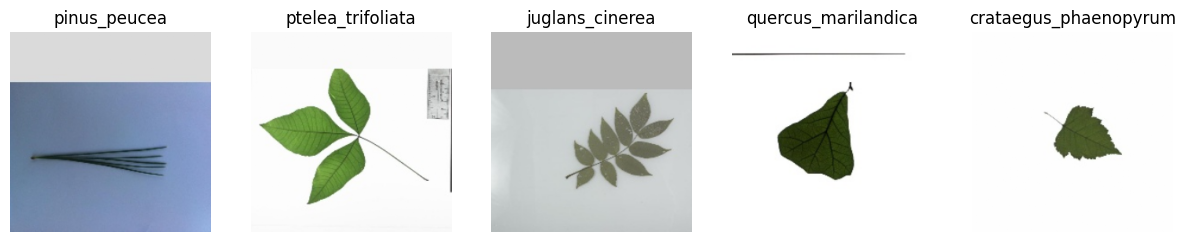

epoch: 0  [0/16517 (0%)]	loss: 5.268355	  train accuracy: 1.31%	 test accuracy:  1.04%
epoch: 0  [80/16517 (8%)]	loss: 5.074856	  train accuracy: 2.34%	 test accuracy:  2.45%
epoch: 0  [160/16517 (15%)]	loss: 4.904248	  train accuracy: 2.72%	 test accuracy:  2.83%
epoch: 0  [240/16517 (23%)]	loss: 4.783141	  train accuracy: 4.08%	 test accuracy:  4.37%
epoch: 0  [320/16517 (31%)]	loss: 4.614428	  train accuracy: 3.00%	 test accuracy:  3.74%
epoch: 0  [400/16517 (38%)]	loss: 4.479062	  train accuracy: 5.56%	 test accuracy:  5.47%
epoch: 0  [480/16517 (46%)]	loss: 4.363150	  train accuracy: 7.14%	 test accuracy:  6.73%
epoch: 0  [560/16517 (54%)]	loss: 4.351830	  train accuracy: 7.41%	 test accuracy:  7.20%
epoch: 0  [640/16517 (62%)]	loss: 3.965706	  train accuracy: 7.90%	 test accuracy:  8.19%
epoch: 0  [720/16517 (69%)]	loss: 3.971204	  train accuracy: 8.88%	 test accuracy:  9.20%
epoch: 0  [800/16517 (77%)]	loss: 3.881504	  train accuracy: 11.60%	 test accuracy:  10.76%
epoch: 0  [88

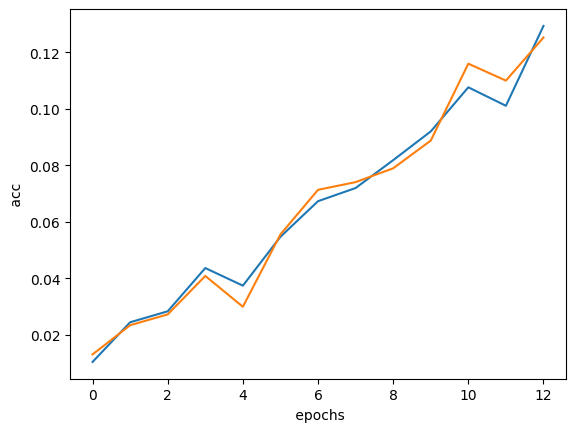

train size:16517,test size:1836
['maclura_pomifera', 'ulmus_rubra', 'broussonettia_papyrifera', 'prunus_virginiana', 'acer_rubrum', 'cryptomeria_japonica', 'staphylea_trifolia', 'asimina_triloba', 'diospyros_virginiana', 'tilia_cordata', 'ulmus_pumila', 'quercus_muehlenbergii', 'juglans_cinerea', 'cercis_canadensis', 'ptelea_trifoliata', 'acer_palmatum', 'catalpa_speciosa', 'abies_concolor', 'eucommia_ulmoides', 'quercus_montana', 'koelreuteria_paniculata', 'liriodendron_tulipifera', 'styrax_japonica', 'malus_pumila', 'prunus_sargentii', 'cornus_mas', 'magnolia_virginiana', 'ostrya_virginiana', 'magnolia_acuminata', 'ilex_opaca', 'acer_negundo', 'fraxinus_nigra', 'pyrus_calleryana', 'picea_abies', 'chionanthus_virginicus', 'carpinus_caroliniana', 'zelkova_serrata', 'aesculus_pavi', 'taxodium_distichum', 'carya_tomentosa', 'picea_pungens', 'carya_glabra', 'quercus_macrocarpa', 'carya_cordiformis', 'catalpa_bignonioides', 'tsuga_canadensis', 'populus_tremuloides', 'magnolia_denudata', 'c

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms


# Define the dataset class
class CustomDataset(Dataset):
	def __init__(self, csv_file, root_dir, transform=None, is_test=False):
		super().__init__()
		self.data = csv_file
		self.root_dir = root_dir
		self.transform = transform
		self.is_test = is_test

	@property
	def classes(self):
		return self.data.iloc[:, 1].unique().tolist()

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		# path example: /kaggle/input/classify-leaves/images/0.jpg
		img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
		image = Image.open(img_path)
		if self.transform:
			image = self.transform(image)
		if self.is_test:
			return image
		label = self.data.iloc[idx, 2]
		label = torch.tensor(label)

		return image, label


# load the dataset and data augment,preprocessing
def load_dataset(batch_size, img_size):
	train_transforms = transforms.Compose([
		transforms.Resize(img_size),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.ToTensor(),
	])
	test_transforms = transforms.Compose([
		transforms.Resize(img_size),
		transforms.ToTensor(),
	])

	# Read the data set
	root_folder = "../data"
	train_csv = pd.read_csv("../data/train.csv")
	test_csv = pd.read_csv("../data/test.csv")

	# label encoder, str to int
	leaves_labels = train_csv.iloc[:, 1].unique()
	n_classes = len(leaves_labels)
	class_to_num = dict(zip(leaves_labels, range(n_classes)))
	train_csv['labelEncoded'] = train_csv.iloc[:, 1].map(class_to_num)

	full_dataset = CustomDataset(train_csv, root_folder, transform=train_transforms)
	predict_dataset = CustomDataset(test_csv, root_folder, transform=test_transforms, is_test=True)

	# split the dataset
	train_size = int(0.9 * len(full_dataset))
	test_size = len(full_dataset) - train_size
	train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
	# dataloader
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
	test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
	dataloaders = {'train': train_dataloader, 'test': test_dataloader}

	print(f"train size:{train_size},test size:{test_size}")
	print(full_dataset.classes)
	return dataloaders, full_dataset.classes, predict_dataset


import matplotlib.pyplot as plt


def display_data(dataloader, class_names):
	# Get a batch of images and labels from the dataloader
	images, labels = next(iter(dataloader["train"]))
	# Display the first 5 images
	fig, axes = plt.subplots(1, 5, figsize=(15, 3))
	for i in range(5):
		axes[i].imshow(images[i].permute(1, 2, 0))  # change the dimension order from (C, H, W) to (H, W, C),
		axes[i].set_title(class_names[labels[i]])
		axes[i].axis('off')
	plt.show()


import torch
from torch import nn
from torch.nn import functional as F


class Residual(nn.Module):  # Basic Residual for ResNet
	def __init__(self, input_channels, num_channels,
				 use_1x1conv=False, strides=1):
		super().__init__()
		self.conv1 = nn.Conv2d(input_channels, num_channels,
							   kernel_size=3, padding=1, stride=strides)
		self.conv2 = nn.Conv2d(num_channels, num_channels,
							   kernel_size=3, padding=1)
		if use_1x1conv:
			self.conv3 = nn.Conv2d(input_channels, num_channels,
								   kernel_size=1, stride=strides)
		else:
			self.conv3 = None
		self.bn1 = nn.BatchNorm2d(num_channels)
		self.bn2 = nn.BatchNorm2d(num_channels)

	def forward(self, X):
		Y = F.relu(self.bn1(self.conv1(X)))
		Y = self.bn2(self.conv2(Y))
		if self.conv3:
			X = self.conv3(X)
		Y += X  # residual
		return F.relu(Y)


def resnet_block(input_channels, num_channels, num_residuals,
				 first_block=False):
	block = []
	for i in range(num_residuals):
		if i == 0 and not first_block:
			block.append(Residual(input_channels, num_channels,
								  use_1x1conv=True, strides=2))
		else:
			block.append(Residual(num_channels, num_channels))
	return block


def resNet_18(n_classes):
	# full ResNet-18
	b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
					   nn.BatchNorm2d(64), nn.ReLU(),
					   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
	b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
	b3 = nn.Sequential(*resnet_block(64, 128, 2))
	b4 = nn.Sequential(*resnet_block(128, 256, 2))
	b5 = nn.Sequential(*resnet_block(256, 512, 2))
	return nn.Sequential(b1, b2, b3, b4, b5,
						 nn.AdaptiveAvgPool2d((1, 1)),
						 nn.Flatten(), nn.Linear(512, n_classes))


net = resNet_18(n_classes=100)
X = torch.rand(size=(1, 3, 256, 256))
for layer in net:
	X = layer(X)
	print(layer.__class__.__name__, 'output shape:\t', X.shape)


def calculate_accuracy(model, data_loader, device):
	correct = 0
	total = 0
	# model.eval()  # Put model in evaluation mode

	with torch.no_grad():
		for data, target in data_loader:
			data, target = data.to(device), target.to(device)
			output = model(data)
			_, predicted = torch.max(output.data, 1)
			total += target.size(0)
			correct += (predicted == target).sum().item()

	return correct / total


# define the train function
import torch.optim as optim


def train(model, dataloaders, epochs, criterion, optimizer):
	train_acc, test_acc = [], []
	for epoch in range(epochs):
		for batch_idx, (data, target) in enumerate(dataloaders['train']):
			data, target = data.to(device), target.to(device)
			optimizer.zero_grad()
			output = model(data)
			loss = criterion(output, target)
			loss.backward()
			optimizer.step()
			# scheduler.step()

			if (batch_idx) % 10 == 0:
				train_accuracy = calculate_accuracy(model, dataloaders['train'], device)
				test_accuracy = calculate_accuracy(model, dataloaders['test'], device)
				train_acc.append(train_accuracy)
				test_acc.append(test_accuracy)
				print(f"epoch: {epoch} ",
					  f"[{batch_idx * batch_size}/{len(dataloaders['train'].dataset)} ({100. * batch_idx / len(dataloaders['train']):.0f}%)]\t"
					  f"loss: {loss.item():.6f}\t ",
					  f"train accuracy: {100. * test_accuracy :.2f}%\t",
					  f"test accuracy:  {100. * train_accuracy:.2f}%")
	plt.plot(list(range(len(train_acc))), train_acc,label='train accuracy')
	plt.plot(list(range(len(train_acc))), test_acc,label='test accuracy')
	plt.xlabel(' epochs')
	plt.ylabel(' acc ')
	plt.savefig('acc.png')
	plt.show()


# GPU training
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
	print('Training on CPU')
else:
	print('Training on GPU')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet18
# batch_size, epochs = 128, 50
batch_size, epochs = 8, 1

dataloaders, class_names, predict_dataset = load_dataset(batch_size=128, img_size=256)
model = resNet_18(len(class_names))
model.to(device)
display_data(dataloaders, class_names)
criterion = nn.CrossEntropyLoss()  # nn.CrossEntropyLoss function includes a softmax
optimizer = optim.Adam(model.parameters(), lr=0.001)  # sdg

train(model, dataloaders, epochs, criterion, optimizer)

# submission
dataloaders, class_names, predict_dataset = load_dataset(batch_size=128, img_size=256)
net, preds = model, []
test_loader = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
for X in test_loader:
	y_hat = net(X.to(device))
	preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
# label encoder, str to int
train_csv = pd.read_csv("../data/train.csv")
leaves_labels = train_csv.iloc[:, 1].unique()
n_classes = len(leaves_labels)
class_to_num = dict(zip(leaves_labels, range(n_classes)))
num_to_class = dict(zip(range(n_classes), leaves_labels))

result = []
for i in preds:
	result.append(num_to_class[i])

test_data = pd.read_csv("../data/test.csv")
test_data['label'] = pd.Series(result)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv("submission.csv", index=False)
print("Done!!!!!!!!!!!!!!!!!!!!!!!!!!!")
